# Custom Bench Stats Visualization and Analysis

We run Minh custom Benchmark using TCmalloc mallocator. The benchmark has multiple producers, each allocates x objects and add them to a queue, and consumers deallocating from that queue. Below are the configurations of the benchmark and tcmalloc.
* benchmark
    * Number of producers = 1000
    * Number of consumers = 1000
    * Number of objects to be allocated = 500
* tcmalloc
    * threshold of live : idle ratio that triggers cpu cache draining = 500

All configurations that are specific to each experiment are described in each section below.

## Set up

In [33]:
import os
import re
import sys
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from natsort import natsorted

In [94]:
class GraphHugePageStats:
    def __init__(self, bench_directory, test_suite, test, release_rates, profile, drain_check_cycle):
        self.bench_directory = bench_directory
        self.set_up_directories()
        self.read_files(os.path.join(bench_directory, "stats_storage", profile_name, test, release_rates, drain_check_cycle))
        # self.deallocate_log = log
        self.PIC_DIR = os.path.join(bench_directory, "pic", profile)
        self.pic_name = profile + "-" + test + "-" + release_rates + "-" + drain_check_cycle
        self.test_name = test

    def set_up_directories(self):
        self.pic_dir = self.bench_directory + "pic/" + profile_name + "/"
        try:
            os.mkdir(self.bench_directory + "pic/")
        except FileExistsError:
            pass

        try:
            os.mkdir(self.pic_dir)
        except FileExistsError:
            pass

    def read_files(self, stats_directory):
        print(stats_directory)
        dict_list = list()

        totalStrandedPage = list()
        totalHugePageRequested = list()
        totalHugePageInUse = list()
        totalHugePageFree = list()
        percentage = list()

        current_hp_in_cache = list()
        current_capacity = list()

        file_list = [os.path.join(stats_directory, f) for f in os.listdir(stats_directory)]
        # print(file_list)
        file_list.sort()
        file_list.sort(key=len)
        # Process files
        for file in file_list:
            hp_dict = dict()
            f = open(file, "r")
            read = f.read()

            # Process per-hugepage stats
            per_hugepage_pattern = "HugePage at addr .+\n\tLive size:\s*\d+\sbytes\n\tCPU Cache Idle size:\s*\d+\sbytes\n\tCentral Cache Idle size:\s*\d+\sbytes\n\tFree size:\s*\d+\sbytes"
            hp_text_list = re.findall(per_hugepage_pattern, read)
            for hp_text in hp_text_list:
                hp_text_lines = hp_text.split("\n")
                addr = hp_text_lines[0].split()[-1]
                live = int(hp_text_lines[1].split()[-2])
                cpu_cache_idle = int(hp_text_lines[2].split()[-2])
                # hp_dict[addr] = (live, cpu_cache_idle)
                if live != 0 or cpu_cache_idle != 0:
                    hp_dict[addr] = (live, cpu_cache_idle)
            dict_list.append(hp_dict)

            # Process stranded page stats
            num_hp_stranded_pattern = "Total\s*\d+ Hugepage\(s\) stranded in all cpu caches."
            text = re.findall(num_hp_stranded_pattern, read)[0]
            num_stranded_page = int(text.split()[1])
            totalStrandedPage.append(num_stranded_page)

            hp_usage_pattern = "HugeAllocator: \d+ requested - \d+ in use = \d+ hugepages free"
            text = re.findall(hp_usage_pattern, read)[0]
            num_requested_page = int(text.split()[1])
            num_inuse_page = int(text.split()[4])
            num_free_page = int(text.split()[8])

            totalHugePageRequested.append(num_requested_page)
            totalHugePageInUse.append(num_inuse_page)
            totalHugePageFree.append(num_free_page)

            percentage.append(num_stranded_page / num_requested_page * 100)

            # Process huge cache stats
            hugecache_pattern = "HugeCache: \d+ \/\ \d+ hugepages cached \/\ cache limit \(\d+.\d+ hit rate, \d+.\d+ overflow rate\)"
            text = re.findall(hugecache_pattern, read)[0]
            words = text.split()
            current_hp_in_cache.append(int(words[1]))
            current_capacity.append(int(words[3]))




        self.dict_list = dict_list

        self.totalStrandedPage = totalStrandedPage
        self.totalHugePageRequested = totalHugePageRequested
        self.totalHugePageInUse = totalHugePageInUse
        self.totalHugePageFree = totalHugePageFree
        self.percentage = percentage

        self.current_hp_in_cache = current_hp_in_cache
        self.current_capacity = current_capacity

    
    def graph_histogram(self, timestamp=0):
        uselessness_list = [(cpu+1)/(live+1) for (live, cpu) in self.dict_list[timestamp].values() if (cpu+1)/(live+1) != 0]
        # uselessness_list = [(cpu+1)/(live+1) for (live, cpu) in self.dict_list[timestamp].values()]
        if 0 in uselessness_list: print("There is 0")
        n, bins, patches = plt.hist(x=uselessness_list, bins=100, color='#0504aa')
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('CPU Cache Idle : Live')
        plt.ylabel('Frequency')
        plt.title('Histogram at time stamp' + str(timestamp))
        # maxfreq = n.max()
        # Set a clean upper y-axis limit.
        # plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
        plt.show()

    def graph_mean_std_timeseries(self):
        x = list(range(len(self.dict_list)))
        means = list()
        stds = list()
        for hp_dict in self.dict_list:
            uselessness_list = [(cpu+1)/(live+1) for (live, cpu) in hp_dict.values()]
            means.append(np.mean(uselessness_list))
            stds.append(np.std(uselessness_list))
        # if self.deallocate_log:
        #     for coor in self.deallocate_log:
        #         plt.axvline(x=coor, c="skyblue", ls='--')
        #         pass
        plt.errorbar(x=x, y=means, yerr=stds, ecolor="r")
        print("Mean of means", np.mean(means))
        plt.xlabel('Time (s)')
        plt.ylabel('Mean of CPU Cache Idle : Live')
        plt.title(self.pic_name)
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.pic_name  + '-Mean CPU Cache Idle.png'), dpi = 100)
        plt.show()
    
    def graph_mean_median_timeseries(self):
        x = list(range(len(self.dict_list)))
        means = list()
        medians = list()
        for hp_dict in self.dict_list:
            uselessness_list = [(cpu+1)/(live+1) for (live, cpu) in hp_dict.values()]
            means.append(np.mean(uselessness_list))
            medians.append(np.median(uselessness_list))
        # if self.deallocate_log:
        #     for coor in self.deallocate_log:
        #         plt.axvline(x=coor, c="skyblue", ls='--')
        #         pass
        plt.plot(x, means,label="mean")
        plt.plot(x, medians,label="median")
        plt.xlabel('Time (s)')
        plt.ylabel('Mean and Median of CPU Cache Idle : Live')
        plt.title(self.pic_name)
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.pic_name  + '-Mean Median CPU Cache Idle.png'), dpi = 100)
        plt.show()

    def plot_stranded_percentage(self):
        textstr = '\n'.join((f"Max Requested HP {max(self.totalHugePageRequested)}",
                            f"Min Requested HP {min(self.totalHugePageRequested)}",
                            f"Max Stranded {max(self.totalStrandedPage)}",
                            f"Min Stranded {min(self.totalStrandedPage)}"))
        plt.plot(self.percentage, label="Percentage")
        plt.xlabel("time (s)")
        plt.ylabel("%")
        plt.title("% Huge Page Stranded in " + self.test_name)

        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.text(0.8, 0.9, textstr, fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.5))
        fig.savefig(os.path.join(self.PIC_DIR, self.test_name + '-HP-Stranded.png'), dpi = 100)
        plt.show()

    def plot_hugepage_usage(self):
        plt.plot(self.totalStrandedPage, label="Stranded Page")
        plt.plot(self.totalHugePageRequested, label="Requested")
        plt.plot(self.totalHugePageInUse, label="In Use")
        plt.plot(self.totalHugePageFree, label="Free")
        plt.legend()
        plt.xlabel("time (s)")
        plt.ylabel("num(s) page")
        plt.title("Huge Page Usage in " + self.test_name)
        
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.test_name + '-HP-Usage.png'), dpi = 100)
        plt.show()

    def plot_huge_cache(self):
        plt.plot(self.current_hp_in_cache, label="Available")
        plt.plot(self.current_capacity, label="Capacity")
        plt.legend()
        plt.xlabel("time (s)")
        plt.ylabel("num(s) page")
        plt.title("Huge Pages in Huge Cache - " + self.test_name)
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.test_name + '-HP-Usage.png'), dpi = 100)
        plt.show()

## Minh Custom Bench

### Beta - 0MB - 0s
* Profile: Beta
* Release rate: 0MB
* No CPU Cache drain

In [95]:
test_suite="minh-custom-bench"
tests=["Producer-Consumer"]
release_rates=["0MB"]
directory="/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/"
profile_name="Beta"
drain_check_cycle="0s"

In [96]:
g = GraphHugePageStats(directory, test_suite=test_suite, test=tests[0], release_rates=release_rates[0],
                       profile=profile_name, drain_check_cycle=drain_check_cycle)

/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/stats_storage/Beta/Producer-Consumer/0MB/0s


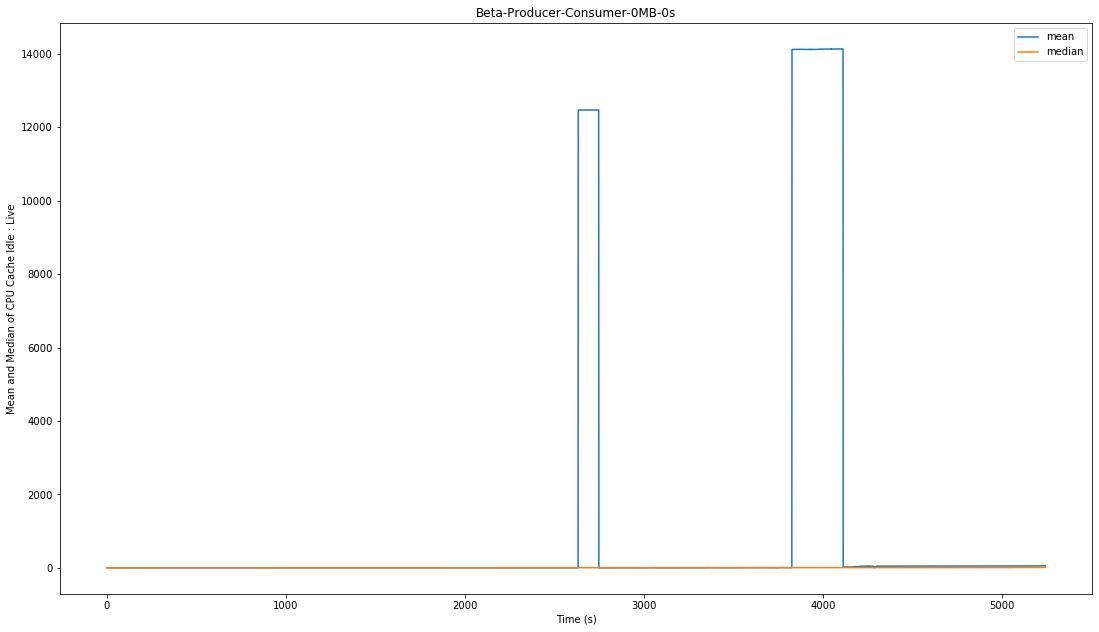

In [97]:
g.graph_mean_median_timeseries()

Mean of means 1055.1178124160842


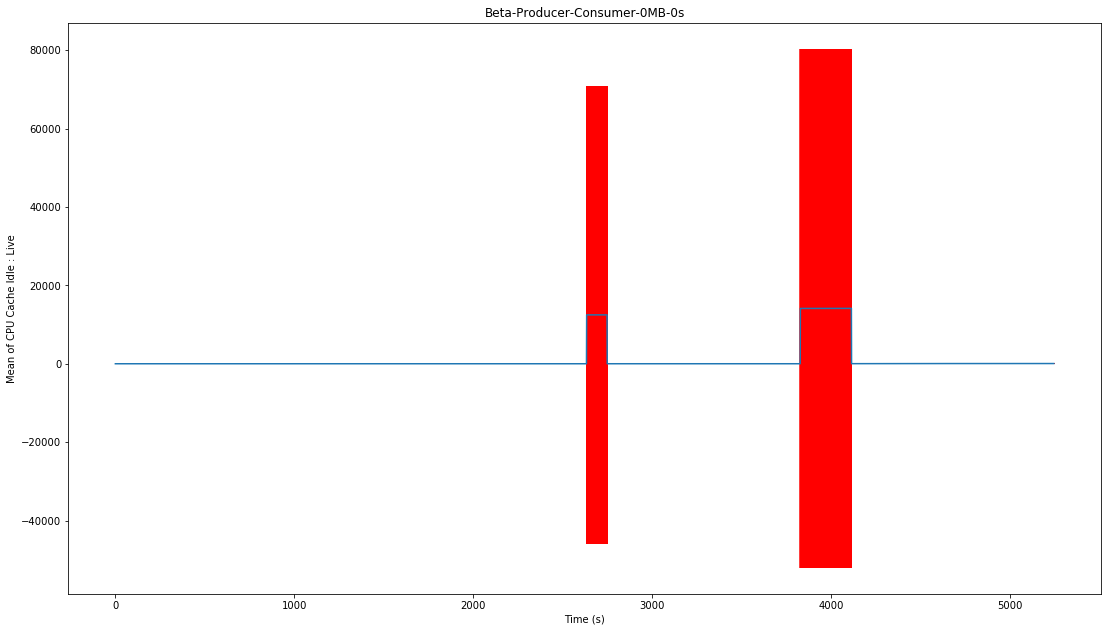

In [98]:
g.graph_mean_std_timeseries()

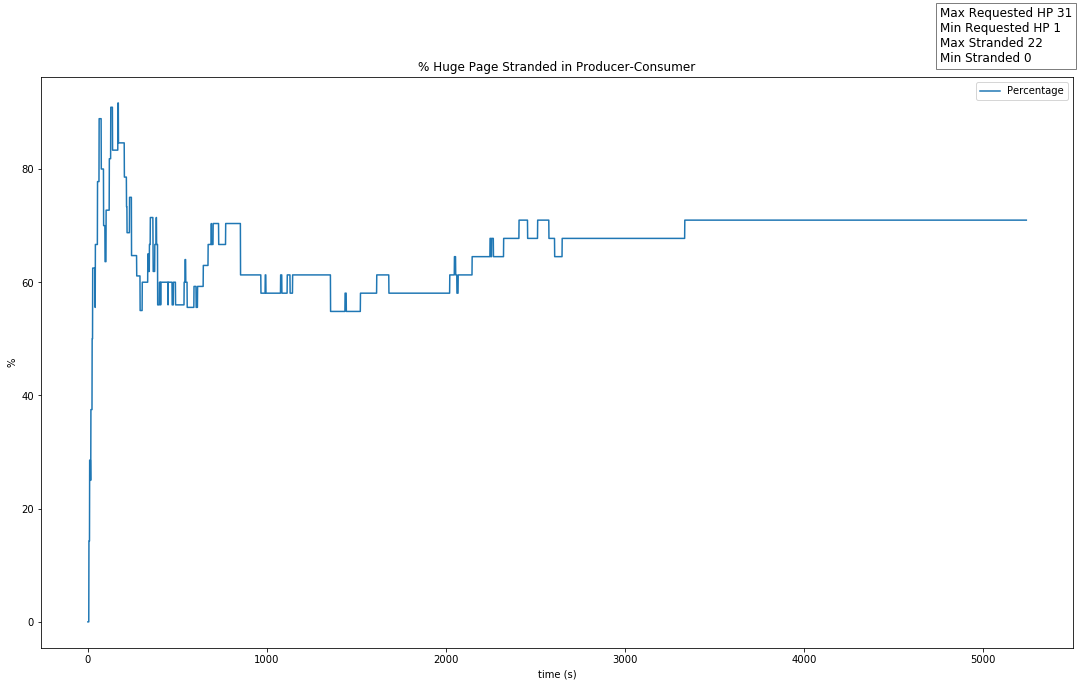

In [99]:
g.plot_stranded_percentage()

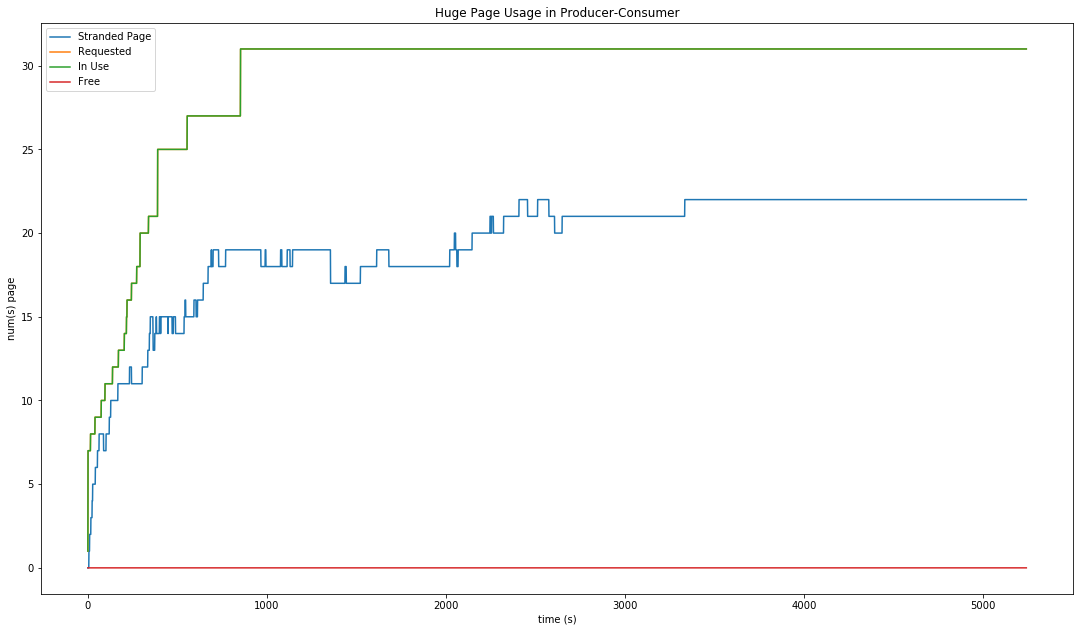

In [100]:
g.plot_hugepage_usage()

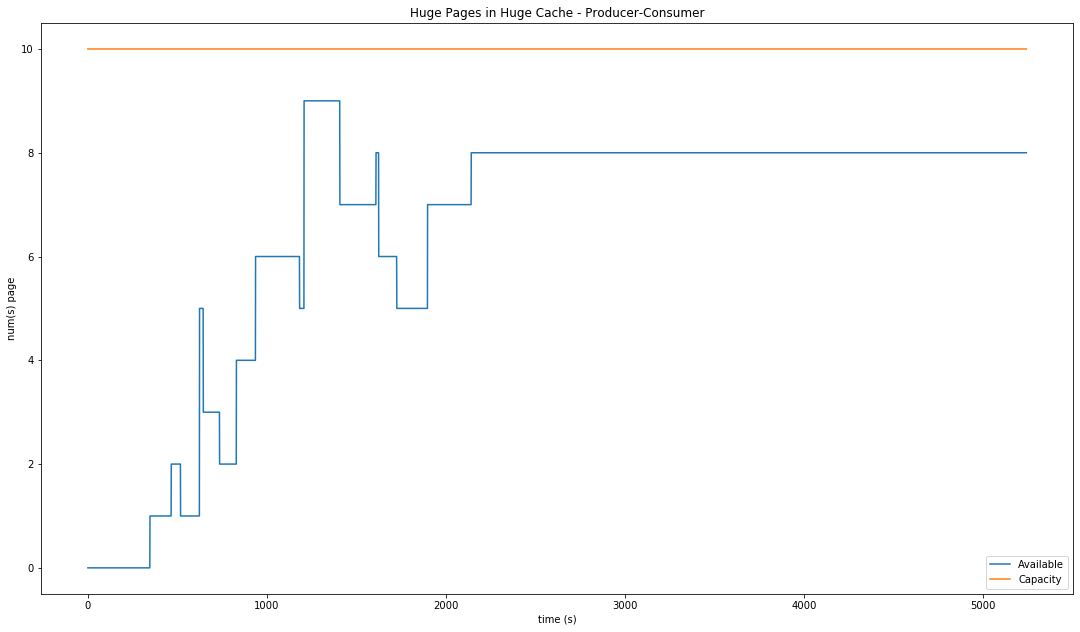

In [101]:
g.plot_huge_cache()

### Beta - 0MB - 1s
* Profile: Beta
* Release rate: 0MB
* For every 1 second, check with threshold = 500 and drain 

In [111]:
test_suite="minh-custom-bench"
tests=["Producer-Consumer"]
release_rates=["0MB"]
directory="/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/"
profile_name="Beta"
drain_check_cycle="1s"

In [112]:
g = GraphHugePageStats(directory, test_suite=test_suite, test=tests[0], release_rates=release_rates[0],
                       profile=profile_name, drain_check_cycle=drain_check_cycle)

/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/stats_storage/Beta/Producer-Consumer/0MB/1s


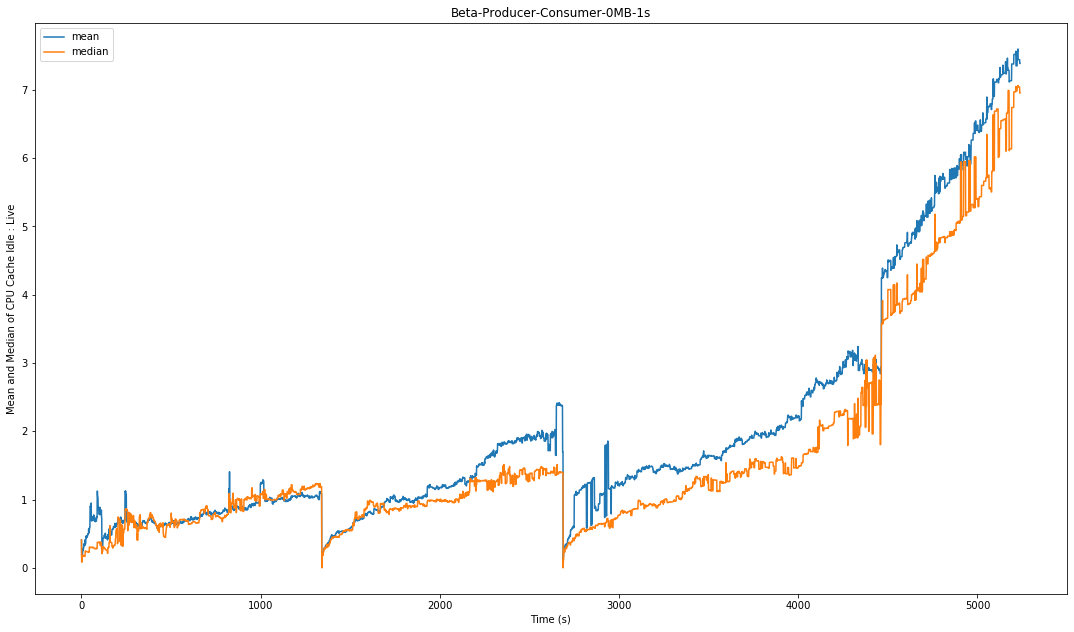

In [113]:
g.graph_mean_median_timeseries()

Mean of means 2.009506471011758


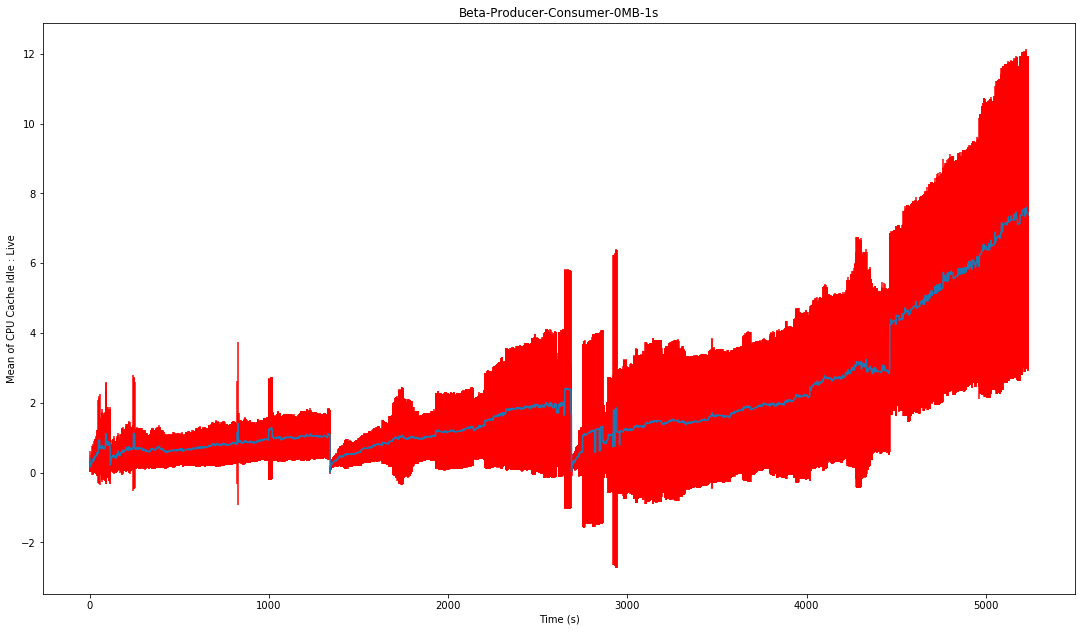

In [114]:
g.graph_mean_std_timeseries()

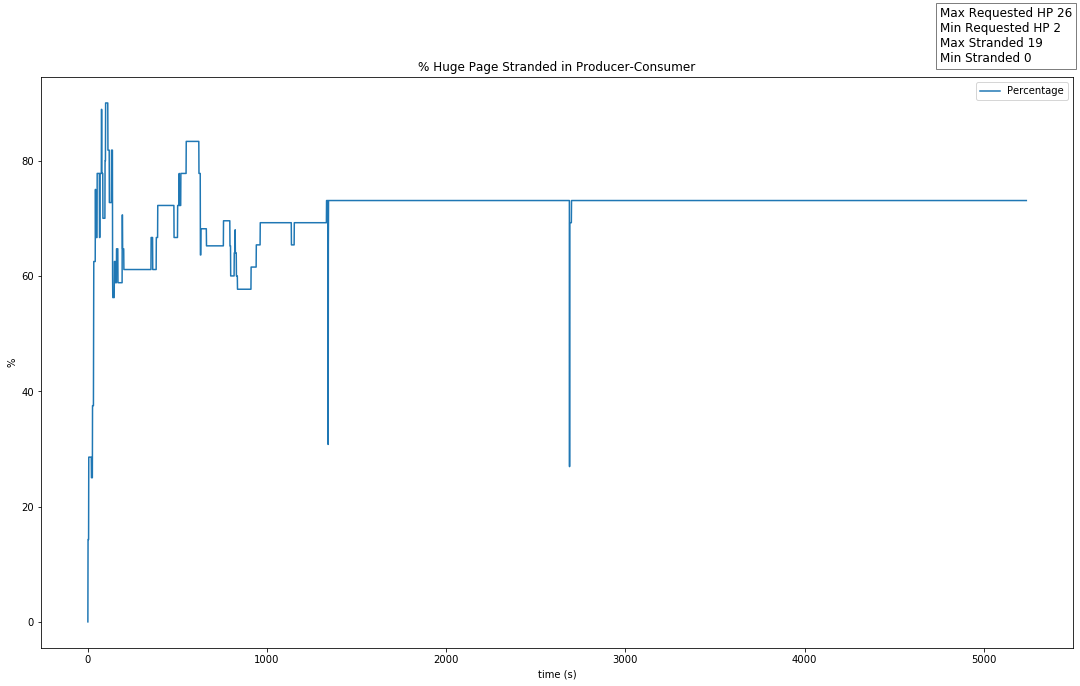

In [115]:
g.plot_stranded_percentage()

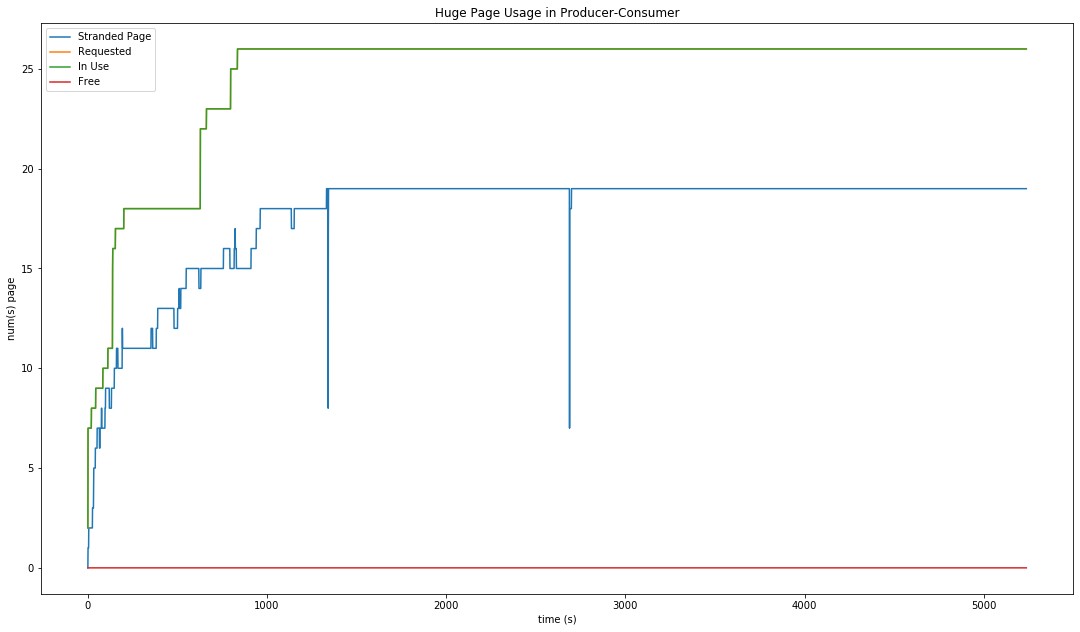

In [116]:
g.plot_hugepage_usage()

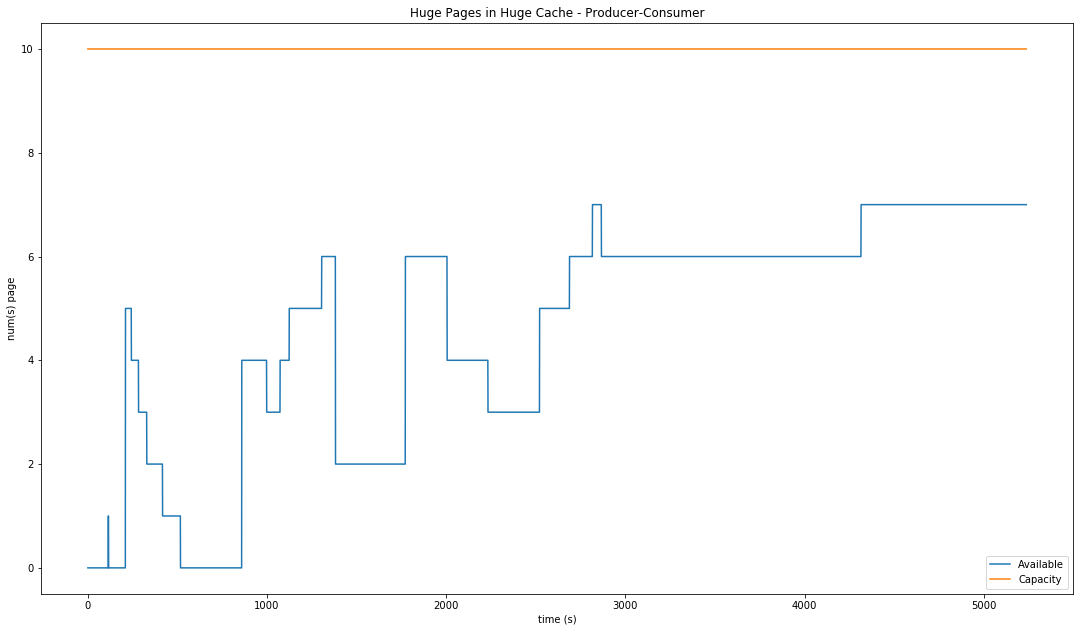

In [117]:
g.plot_huge_cache()